In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn.model_selection import train_test_split # for splitting the data into train and test samples
from sklearn.metrics import classification_report # for model evaluation metrics
from sklearn.preprocessing import OrdinalEncoder # for encoding categorical features from strings to number arrays
from sklearn.naive_bayes import CategoricalNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import KFold

In [2]:
# Function that handles sample splitting, model fitting and report printing 
def holdout(X, y, typ):
    
    """ Holdout validation """
    # Create training and testing samples
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

    # Fit the model
    model = typ
    clf = model.fit(X_train, y_train)
    
    # class 'e' = positive
    TP, FP, FN, TN = 0, 0, 0, 0
    pred = clf.predict(X_test)
    for i in range(len(X_test)):
        if pred[i] == 'e' and y_test[i] == 'e':
            TP += 1
        elif pred[i] == 'e' and y_test[i] == 'p':
            FP += 1
        elif pred[i] == 'p' and y_test[i] == 'e':
            FN += 1
        elif pred[i] == 'p' and y_test[i] == 'p':
            TN += 1
    confusion_mat = pd.DataFrame([[TP, FP], [FN, TN]])
    acc = (TP+TN)/len(X_test)
    recall = TP/(TP+FN)
    precision = TP/(TP+FP)
    
    # Return relevant data for chart plotting
    return clf, confusion_mat, acc, recall, precision

In [3]:
def kfold(X, y, typ):
    
    """ K-fold """
    K = 3
    kf_clfs = []
    score_sum = 0
    
    kf = KFold(n_splits=K)
    mats, accs, recalls, precisions = [], [], [], []
    for train_index, test_index in kf.split(X,y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # Fit the model
        model = typ
        clf = model.fit(X_train, y_train)
        kf_clfs.append(clf)
        
        # class 'e' = positive
        TP, FP, FN, TN = 0, 0, 0, 0
        pred = clf.predict(X_test)
        for i in range(len(X_test)):
            if pred[i] == 'e' and y_test[i] == 'e':
                TP += 1
            elif pred[i] == 'e' and y_test[i] == 'p':
                FP += 1
            elif pred[i] == 'p' and y_test[i] == 'e':
                FN += 1
            elif pred[i] == 'p' and y_test[i] == 'p':
                TN += 1
        mats.append(pd.DataFrame([[TP, FP], [FN, TN]]))
        accs.append((TP+TN)/len(X_test))
        recalls.append(TP/(TP+FN))
        precisions.append(TP/(TP+FP))
    
    confusion_mat = (mats[0]+mats[1]+mats[2])/3
    acc = sum(accs) / K
    recall = sum(recalls) / K
    precision = sum(precisions) / K
    
    # Return relevant data for chart plotting
    return kf_clfs, confusion_mat, acc, recall, precision

In [20]:
""" Data input """

name_list = ['edible','cap-shape','cap-surface','cap-color','bruises','odor','gill-attachment','gill-spacing','gill-size','gill-color','stalk-shape','stalk-root','stalk-surface-above-ring','stalk-surface-below-ring','stalk-color-above-ring','stalk-color-below-ring','veil-type','veil-color','ring-number','ring-type','spore-print-color','population','habitat']
data = pd.read_csv('agaricus-lepiota.data', sep=",", names=name_list)
feature_list = name_list
feature_list.remove('edible')
attribute_list = [['b','c','x','f','k','s'],['f','g','y','s'],['n','b','c','g','r','p','u','e','w','y'],['t','f'],['a','l','c','y','f','m','n','p','s'],['a','d','f','n'],['c','w','d'],['b','n'],['k','n','b','h','g','r','o','p','u','e','w','y'],['e','t'],['b','c','u','e','z','r'],['f','y','k','s'],['f','y','k','s'],['n','b','c','g','o','p','e','w','y'],['n','b','c','g','o','p','e','w','y'],['p','u'],['n','o','w','y'],['n','o','t'],['c','e','f','l','n','p','s','z'],['k','n','b','h','r','o','u','w','y'],['a','c','n','s','v','y'],['g','l','m','p','u','w','d']]
cate_num_list = [6,4,10,2,9,4,3,2,12,2,4,4,9,9,2,4,3,8,9,6,7]

""" Data preprocessing """

# Drop feature w/ missing value 
data = data.drop(columns='stalk-root')
feature_list.remove('stalk-root')

# shuffle
data = data.sample(frac=1)

In [21]:
# Select data for modeling
X=data[feature_list]
y=data['edible'].values

enc = OrdinalEncoder()
X = enc.fit_transform(X)

In [38]:
""" Model Constructiong & Validation """

# without Laplace
holdout_clf, mat, acc, recall, precision = holdout(X,y,CategoricalNB(alpha=1e-10, min_categories=cate_num_list))
kf_clfs, mat2, acc2, recall2, precision2 = kfold(X,y,CategoricalNB(alpha=1e-10, min_categories=cate_num_list))

# with Laplace
alpha_=1
holdout_clf_l, mat_l, acc_l, recall_l, precision_l = holdout(X,y,CategoricalNB(alpha=alpha_, min_categories=cate_num_list))
kf_clfs_l, mat_l2, acc_l2, recall_l2, precision_l2 = kfold(X,y,CategoricalNB(alpha=alpha_, min_categories=cate_num_list))

# Plot table
con_mat_table = pd.DataFrame([[mat[0][0], mat[1][0], mat2[0][0], mat2[1][0]],[mat[0][1], mat[1][1], mat2[0][1], mat2[1][1]]],
                  index=pd.Index(['e (positive)', 'p (negative)'], name='Predicted:'),
                  columns=pd.MultiIndex.from_product([['Holdout', 'K-fold'],['e', 'p']], names=['Validation:', 'Actual:']))

con_mat_table_l = pd.DataFrame([[mat_l[0][0], mat_l[1][0], mat_l2[0][0], mat_l2[1][0]],[mat_l[0][1], mat_l[1][1], mat_l2[0][1], mat_l2[1][1]]],
                  index=pd.Index(['e (positive)', 'p (negative)'], name='Predicted:'),
                  columns=pd.MultiIndex.from_product([['Holdout', 'K-fold'],['e', 'p']], names=['Validation:', 'Actual:']))

performance_table = pd.DataFrame([[acc, recall, precision, acc2, recall2, precision2], [acc_l, recall_l, precision_l, acc_l2, recall_l2, precision_l2]],
                  index=pd.Index(['Without Laplace', 'With Laplace'], name='Smoothing:'),
                  columns=pd.MultiIndex.from_product([['Holdout', 'K-fold'],['Accuracy', 'Recall', 'Precision']], names=['Validation:', 'Performance:']))

In [39]:
con_mat_table

Validation:  Holdout             K-fold             
Actual:            e     p            e            p
Predicted:                                          
e (positive)    1249     1  1395.666667     1.000000
p (negative)       8  1180     7.000000  1304.333333

In [40]:
con_mat_table_l

Validation:  Holdout             K-fold             
Actual:            e     p            e            p
Predicted:                                          
e (positive)    1249   104  1395.000000   104.333333
p (negative)       8  1077     7.666667  1201.000000

In [34]:
performance_table

Validation:       Holdout                        K-fold                    
Performance:     Accuracy    Recall Precision  Accuracy    Recall Precision
Smoothing:                                                                 
Without Laplace  0.996308  0.993636  0.999200  0.997046  0.995069  0.999295
With Laplace     0.954061  0.993636  0.923134  0.958641  0.994599  0.930396

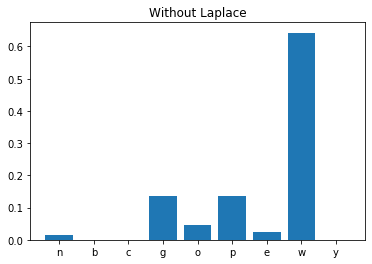

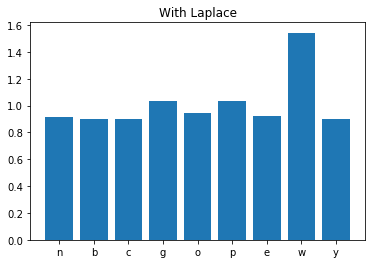

In [206]:
""" Question """

cate_list = ['n','b','c','g','o','p','e','w','y']
num_Xi_y = [0,0,0,0,0,0,0,0,0]

filter_e = (data['edible']=='e')
num_y = len(data[filter_e])
cnt = data[filter_e]['stalk-color-below-ring'].value_counts()
num_Xi_y[7] = cnt[0]
num_Xi_y[3] = cnt[1]
num_Xi_y[5] = cnt[2]
num_Xi_y[4] = cnt[3]
num_Xi_y[6] = cnt[4]
num_Xi_y[0] = cnt[5]

# Without Laplace
prob = [x / num_y for x in num_Xi_y]

# With Laplace
alpha = 0.1
prob_l = [(x+alpha) / num_y+(alpha*len(cate_list)) for x in num_Xi_y]

# Plot
plt.figure()
plt.title("Without Laplace")
plt.bar(list(range(9)), prob, tick_label=cate_list)

plt.figure()
plt.title("With Laplace")
plt.bar(list(range(9)), prob_l, tick_label=cate_list)

plt.show()

------------------- Feature = cap-shape -------------------


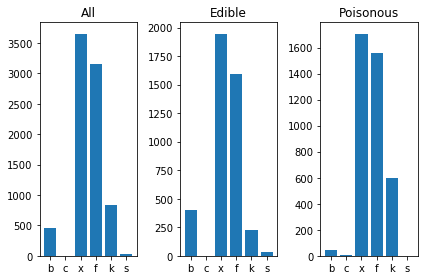

------------------- Feature = cap-surface -------------------


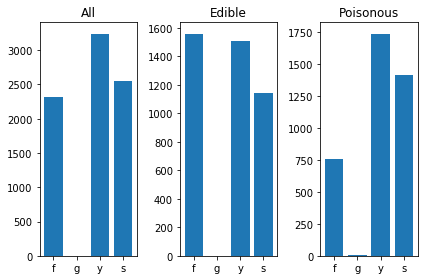

------------------- Feature = cap-color -------------------


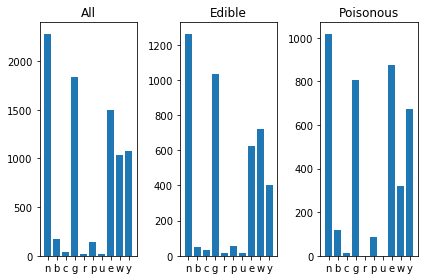

------------------- Feature = bruises -------------------


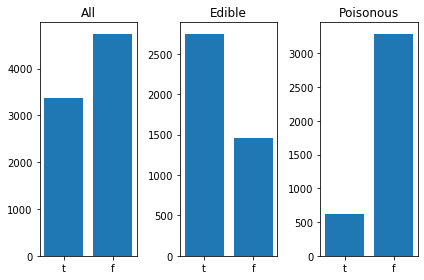

------------------- Feature = odor -------------------


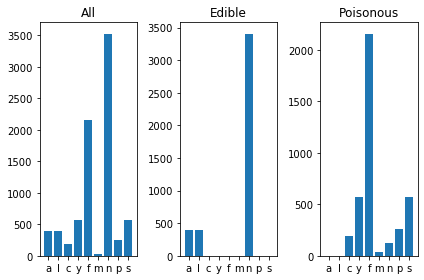

------------------- Feature = gill-attachment -------------------


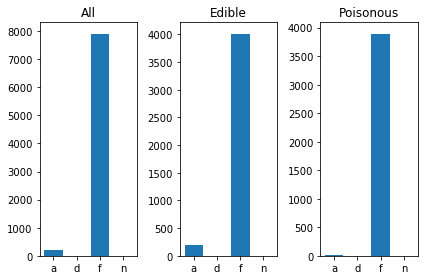

------------------- Feature = gill-spacing -------------------


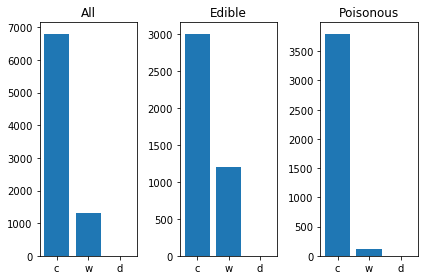

------------------- Feature = gill-size -------------------


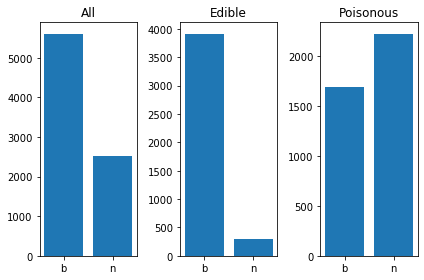

------------------- Feature = gill-color -------------------


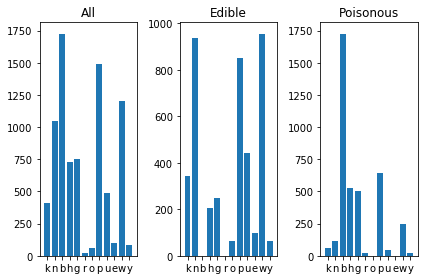

------------------- Feature = stalk-shape -------------------


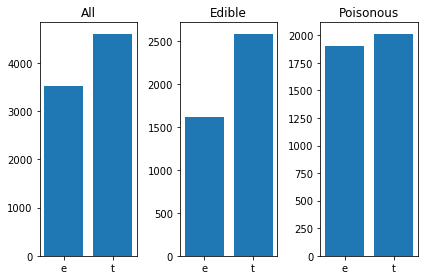

------------------- Feature = stalk-surface-above-ring -------------------


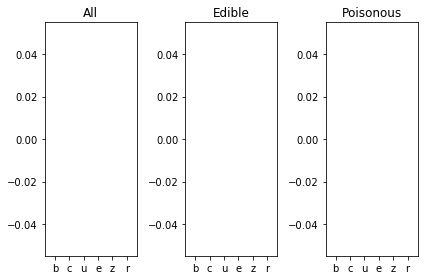

------------------- Feature = stalk-surface-below-ring -------------------


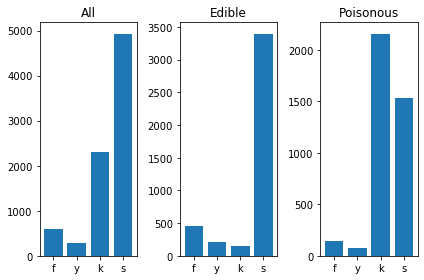

------------------- Feature = stalk-color-above-ring -------------------


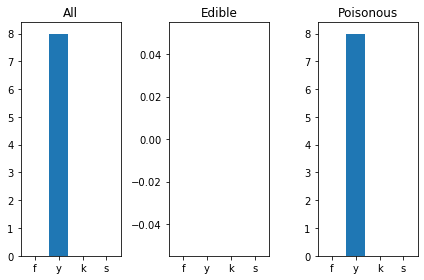

------------------- Feature = stalk-color-below-ring -------------------


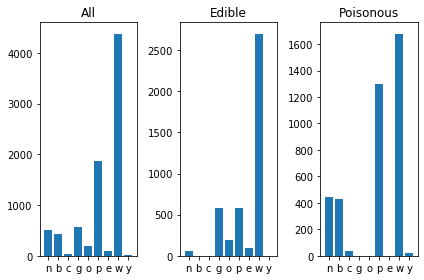

------------------- Feature = veil-type -------------------


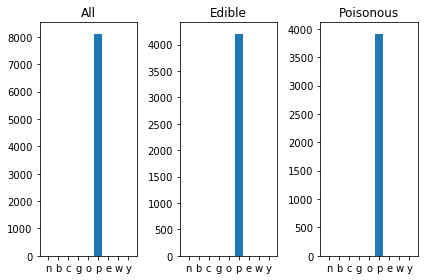

------------------- Feature = veil-color -------------------


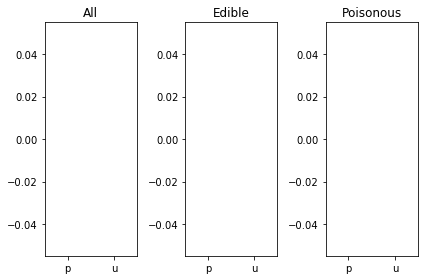

------------------- Feature = ring-number -------------------


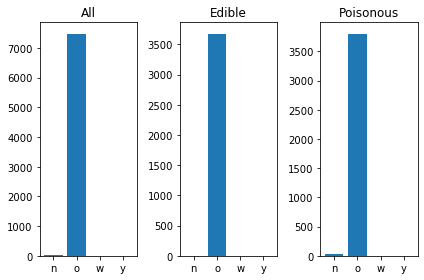

------------------- Feature = ring-type -------------------


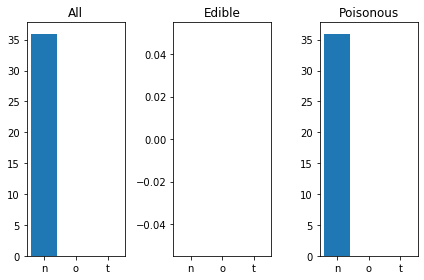

------------------- Feature = spore-print-color -------------------


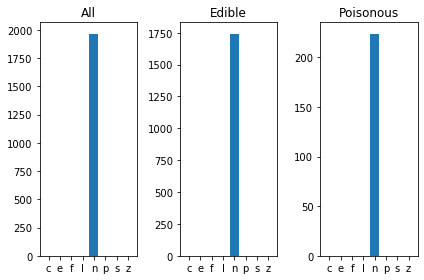

------------------- Feature = population -------------------


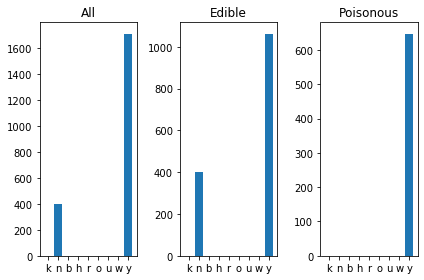

------------------- Feature = habitat -------------------


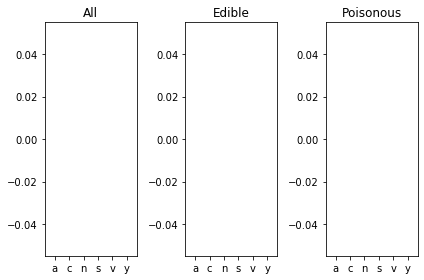

In [41]:
""" Data visualization (Mushroom) """

for i, feature in enumerate(feature_list):
    attributes = attribute_list[i]
    x, y, x_e, y_e, x_p, y_p = [], [], [], [], [], []
    for i in range(len(attributes)):
        filter1 = (data[feature] == attributes[i])
        x.append(i)
        y.append(len(data[filter1]))
        
        filter2 = (data['edible']=='e')
        x_e.append(i)
        y_e.append(len(data[filter1 & filter2]))
        
        filter2 = (data['edible']=='p')
        x_p.append(i)
        y_p.append(len(data[filter1 & filter2]))
    
    plt.figure()
    print("------------------- Feature = " + feature + " -------------------")
    plt.subplot(1,3,1)
    plt.title("All")
    plt.bar(x, y, tick_label=attributes)
    
    plt.subplot(1,3,2)
    plt.title("Edible")
    plt.bar(x_e, y_e, tick_label=attributes)
    
    plt.subplot(1,3,3)
    plt.title("Poisonous")
    plt.bar(x_p, y_p, tick_label=attributes)
    
    plt.tight_layout()
    plt.show()